[View in Colaboratory](https://colab.research.google.com/github/eltiotino/darwins/blob/master/20181017_rackpub2.ipynb)

In [1]:
%pylab inline
!pip install pandas-datareader
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import numpy.random as rng
import pandas_datareader.data as web
import numpy as np
import pandas as pd
!pip install ta
import ta
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
!pip install fix_yahoo_finance
!pip install ffn
import fix_yahoo_finance as yf
import ffn
yf.pdr_override() # Importamos Pandas Datareader y lo parcheamos para que funcione con Yahoo


Populating the interactive namespace from numpy and matplotlib
    100% |████████████████████████████████| 112kB 2.7MB/s 
    100% |████████████████████████████████| 5.8MB 5.0MB/s 
  Running setup.py bdist_wheel for ta ... - done
  Stored in directory: /root/.cache/pip/wheels/22/0f/f9/73da681974d2e7fbffc73c6c6aef959afe3aac51e96b389847
Successfully built ta
  Running setup.py bdist_wheel for fix-yahoo-finance ... - done
  Stored in directory: /root/.cache/pip/wheels/2c/ca/ce/218a19aaecf63fd74c75d6a6772b1a799fa05826d8762bfd83
  Running setup.py bdist_wheel for multitasking ... - done
  Stored in directory: /root/.cache/pip/wheels/41/e4/48/af808a1c57f43f104042abdaf80fa623ab213ca0268ba4189c
Successfully built fix-yahoo-finance multitasking
    100% |████████████████████████████████| 51kB 3.9MB/s 
  Running setup.py bdist_wheel for ffn ... - done
  Stored in directory: /root/.cache/pip/wheels/20/08/4d/921180e81279d147cb6399fe1e194f2c67a796df86f9f4c5fe
  Running setup.py bdist_wheel 

In [0]:

def strategy_performance(stock_ticker,periodo):  
    stock = pdr.get_data_yahoo(stock_ticker, start="2008-01-01", end="2018-10-01")         
    
    
    #Compute periodo -days breakout and mean.

    # 5-days high  
    stock['high'] = stock['Adj Close'].shift(1).rolling(window=periodo).max()  
    # 5-days low  
    stock['low'] = stock['Adj Close'].shift(1).rolling(window=periodo).min()  
    # 5-days mean  
    stock['avg'] = stock['Adj Close'].shift(1).rolling(window=periodo).mean()  

    #Entry Rules
    #When the closing price of the stock is greater than the high of past 55 days 
    #then we go long on the stock and 
    #when the closing price of the stock is less than the low of past 55 days 
    #then we go short on the stock.

    stock['long_entry'] = stock['Adj Close'] > stock.high         
    stock['short_entry'] = stock['Adj Close'] < stock.low  

    #stock['signal']=np.where(stock['Adj Close'] > stock.high,1,np.nan)
    
    #stock['signal']=np.where(stock['Adj Close'] < stock.low,1,stock['signal'])
    #Exit Rules

    #We will exit the positions if the stock price crosses the mean of past 55 days.

    stock['long_exit'] = stock['Adj Close'] < stock.avg  
    stock['short_exit'] = stock['Adj Close'] > stock.avg  

    #stock['signal']=np.where(stock['Adj Close'].shift() > stock.avg.shift(),0,stock['signal'])
    #stock['signal']=np.where(stock['Adj Close'].shift() < stock.avg.shift(),0,stock['signal'])

    
    #Positions
    
    #We will now store the entry and exit signal in a single column. Long position is indicated by 1, short position is indicated by -1 and exit or no position is indicated by 0. We will carry forward the previous position if no position exists for a time period using the fillna method.

    stock['positions_long'] = np.nan    
    stock.loc[stock.long_entry,'positions_long']= 1    
    stock.loc[stock.long_exit,'positions_long']= 0    
    
    stock['positions_short'] = np.nan    
    stock.loc[stock.short_entry,'positions_short']= 0    
    stock.loc[stock.short_exit,'positions_short']= 0    
  
    stock['Signal'] = stock.positions_long + stock.positions_short  
  
    stock= stock.fillna(method='ffill')   
    #stock=stock.fillna(0,inplace=True)
    
    #print(stock)
    #Strategy Returns
    
    #We have computed the log returns of the stock and multiplied with the Signal (1,-1 or 0) to get the strategy returns.

    daily_log_returns = np.log(stock['Adj Close']/stock['Adj Close'].shift(1))  
    daily_log_returns = daily_log_returns * stock.Signal.shift(1)  
  
    # Plot the distribution of 'daily_log_returns'  
    print (stock_ticker)  
    daily_log_returns.hist(bins=50)  
    plt.show()  
    return daily_log_returns.cumsum() 



[*********************100%***********************]  1 of 1 downloaded
tef.mc


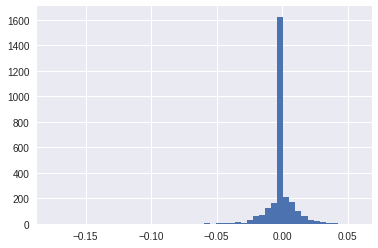

[*********************100%***********************]  1 of 1 downloaded
tef.mc


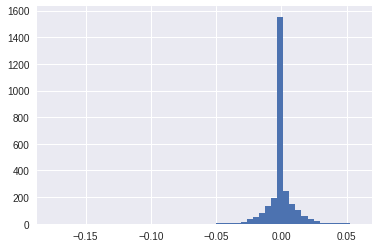

[*********************100%***********************]  1 of 1 downloaded
tef.mc


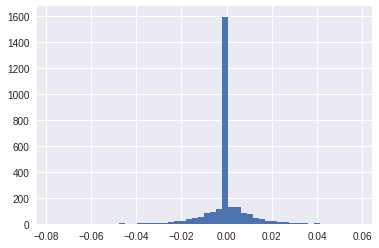

[*********************100%***********************]  1 of 1 downloaded
tef.mc


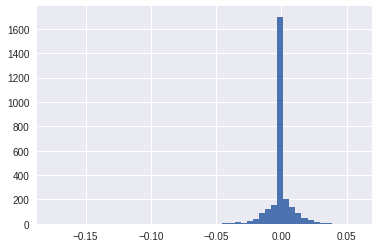

[*********************100%***********************]  1 of 1 downloaded
tef.mc


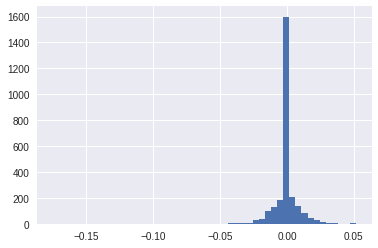

[*********************100%***********************]  1 of 1 downloaded
tef.mc


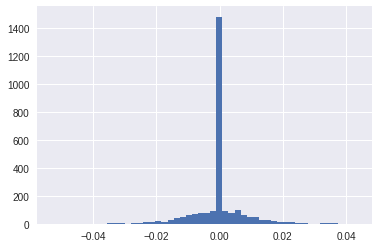

[*********************100%***********************]  1 of 1 downloaded
tef.mc


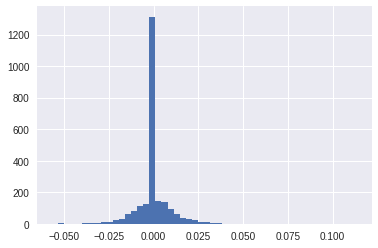

[*********************100%***********************]  1 of 1 downloaded
san.mc


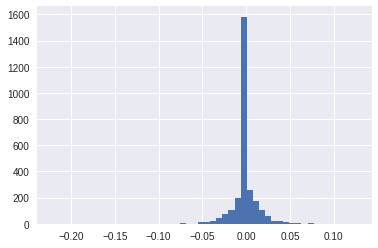

[*********************100%***********************]  1 of 1 downloaded
san.mc


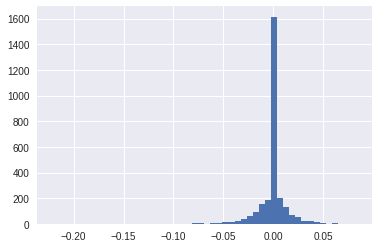

[*********************100%***********************]  1 of 1 downloaded
san.mc


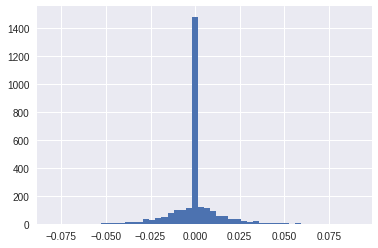

[*********************100%***********************]  1 of 1 downloaded
san.mc


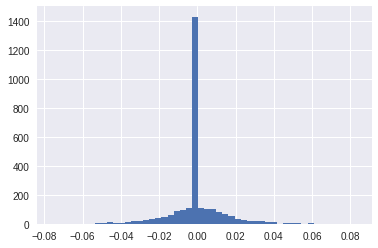

[*********************100%***********************]  1 of 1 downloaded
san.mc


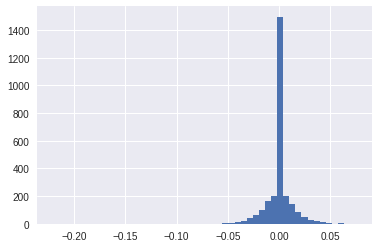

[*********************100%***********************]  1 of 1 downloaded
san.mc


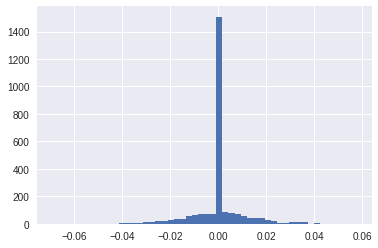

[*********************100%***********************]  1 of 1 downloaded
san.mc


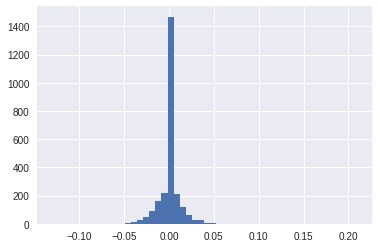

[*********************100%***********************]  1 of 1 downloaded
itx.mc


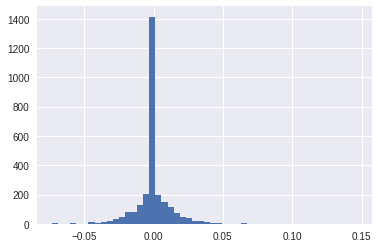

[*********************100%***********************]  1 of 1 downloaded
itx.mc


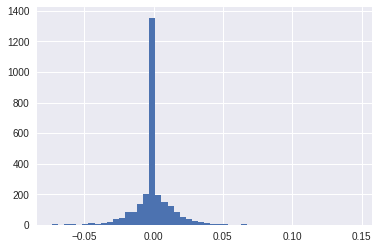

[*********************100%***********************]  1 of 1 downloaded
itx.mc


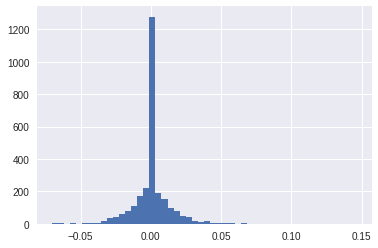

[*********************100%***********************]  1 of 1 downloaded
itx.mc


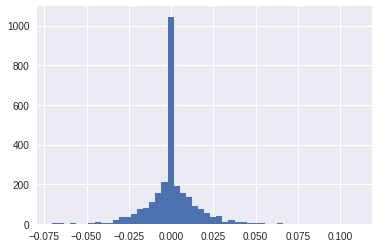

[*********************100%***********************]  1 of 1 downloaded
itx.mc


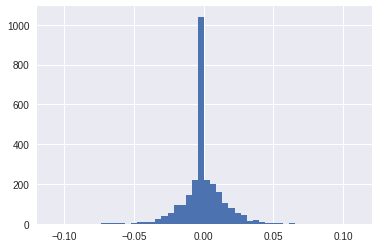

[*********************100%***********************]  1 of 1 downloaded
itx.mc


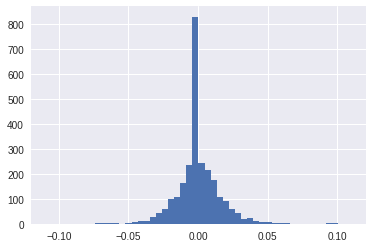

[*********************100%***********************]  1 of 1 downloaded
itx.mc


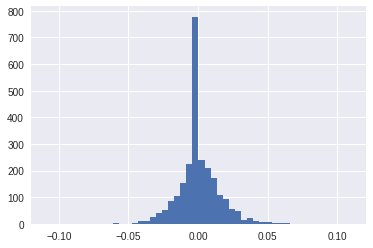

[*********************100%***********************]  1 of 1 downloaded
rep.mc


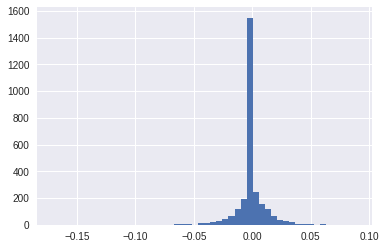

[*********************100%***********************]  1 of 1 downloaded
rep.mc


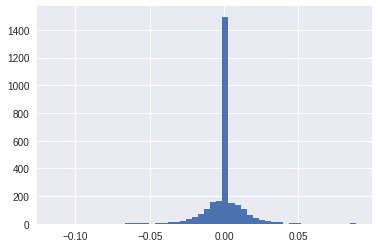

[*********************100%***********************]  1 of 1 downloaded
rep.mc


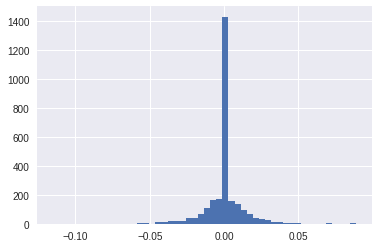

[*********************100%***********************]  1 of 1 downloaded
rep.mc


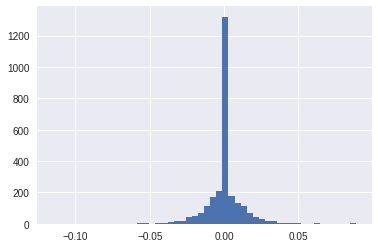

[*********************100%***********************]  1 of 1 downloaded
rep.mc


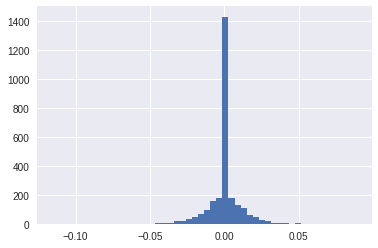

[*********************100%***********************]  1 of 1 downloaded
rep.mc


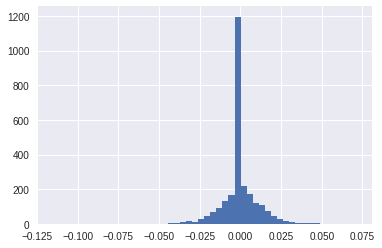

[*********************100%***********************]  1 of 1 downloaded
rep.mc


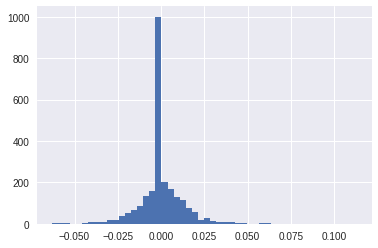

Cumulative Daily Returns


In [3]:

#Step 3: Create a portfolio of stocks and calculate the strategy performance for each stock.

portfolio = ['AAPL','KMI','F','GOOG','AMZN']
portfolio = ['MMM','GOOG','xlu','AAPL']
portfolio = ['tef.mc','san.mc','itx.mc','rep.mc']

periodos = [ 5, 10 , 20 , 40 ,60, 110, 220]
#portfolio = ['QQQ']
#periodos = [ 5]
cum_daily_log_return = pd.DataFrame()  
for stock in portfolio:   
  for periodo in periodos:
    nombre='{}_l{}'.format(stock,periodo)
    cum_daily_log_return[nombre] = strategy_performance(stock,periodo)  

# Plot the cumulative daily returns  
print ("Cumulative Daily Returns")  
#cum_daily_log_return.plot()  
# Show the plot  
#plt.show()  

In [0]:
#extre los datos en %
cum_daily_return=np.exp(cum_daily_log_return)

In [0]:
#extrae los rendimientos de 3 meses para todas las estrategias
#rel_cum_daily_return=cum_daily_return.pct_change(60).fillna(0)

In [0]:
#plotea los 500 ultimos valores de la series
#rel_cum_daily_return[-500:].plot()

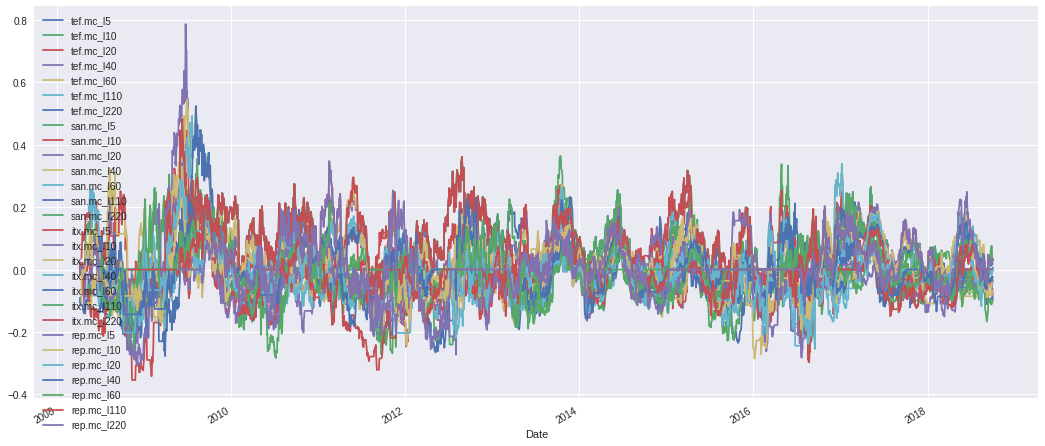

In [7]:
#plotea todos los valores
cum_daily_return.pct_change(60).plot(figsize=(18,8))

In [0]:
#grafica los valores en funcion del periodod
portfolio_grupo={}
cum_daily_return['neutro']=0
cum_daily_return['neutro_l5']=0.000001
cum_daily_return['neutro_l10']=0.000001
cum_daily_return['neutro_l20']=0.000001
cum_daily_return['neutro_l60']=0.000001
cum_daily_return['neutro_l110']=0.000001
cum_daily_return['neutro_l220']=0.000001

for periodo in periodos:

    f1=pd.DataFrame(index=cum_daily_return.index)
    #print ('Grafico del periodo',periodo)
    l5=cum_daily_return.filter(like='_l{}'.format(periodo),axis=1).columns.values
    #l4='neutro'
    #l5=np.append(l5,l4)
    portfolio_grupo[periodo]=dict(periodo=l5)
      
#    for periodo2 in periodos:

        #f1=pd.DataFrame(index=cum_daily_return.index)
        #print ('Grafico del periodo',periodo)
        #l5=cum_daily_return.filter(like='_l{}'.format(periodo),axis=1).columns.values
#        cum_daily_return[l5].pct_change(periodo2).plot(figsize=(16,8),title='grafico en {} y pct {}'.format(periodo,periodo2))

In [9]:
#obiene las series por periodo
portfolio_grupo[5]['periodo']



array(['tef.mc_l5', 'san.mc_l5', 'itx.mc_l5', 'rep.mc_l5', 'neutro_l5'],
      dtype=object)

In [10]:
'''
cum_daily_return[portfolio_grupo[220]['periodo']].pct_change(60).plot()
cum_daily_return['pepe']=cum_daily_return[portfolio_grupo[220]['periodo']].pct_change(110).apply(lambda x: x.argmax(), axis=1)
print (cum_daily_return['pepe'].tail())
print (cum_daily_return[portfolio_grupo[220]['periodo']].pct_change(110).tail())
'''

"\ncum_daily_return[portfolio_grupo[220]['periodo']].pct_change(60).plot()\ncum_daily_return['pepe']=cum_daily_return[portfolio_grupo[220]['periodo']].pct_change(110).apply(lambda x: x.argmax(), axis=1)\nprint (cum_daily_return['pepe'].tail())\nprint (cum_daily_return[portfolio_grupo[220]['periodo']].pct_change(110).tail())\n"

In [11]:
resultados= []
for periodo in periodos:
  for periodo2 in periodos:
    nombre='resultado_{}d{}p'.format(periodo,periodo2)
    resultados.append(nombre)
    cum_daily_return[nombre]=cum_daily_return[portfolio_grupo[periodo]['periodo']].pct_change(periodo2).apply(lambda x: x.argmax(), axis=1)
    #hay que poner el pct_change


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  


In [0]:
#cum_daily_return


In [12]:
#tenemos neutro y nada mas
"""
f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='neutro'.format(periodo),axis=1).columns.values
cum_daily_return[l5].plot(figsize=(16,8))
"""

"\nf1=pd.DataFrame(index=cum_daily_return.index)\nl5=cum_daily_return.filter(like='neutro'.format(periodo),axis=1).columns.values\ncum_daily_return[l5].plot(figsize=(16,8))\n"

In [0]:
#resultados

In [0]:
#cum_daily_return[resultados].tail()

In [0]:

#print (cum_daily_return.columns)
#for columna in resultados:
  
 # daily_log_return=np.log(cum_daily_return[portfolio]/cum_daily_return[portfolio].shift())

In [0]:
#calcula los retornos en log

f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='_l'.format(periodo),axis=1).columns.values
for fila in l5:
  nombre='p_'+fila
  cum_daily_return[nombre]=np.log(cum_daily_return[fila]/cum_daily_return[fila].shift())

In [0]:
#print (cum_daily_return['p_AAPL_l60'])

In [0]:
#cum_daily_return['p_AAPL_l60'].tail()

In [0]:
#print (cum_daily_return['resultado_5d60p'].tail())
#print(cum_daily_return['resultado_5d110p'].value_counts())

In [0]:
#cum_daily_return

In [21]:
"""
print (portfolio)
print (resultados)
print (periodos)
print (periodos)
"""

'\nprint (portfolio)\nprint (resultados)\nprint (periodos)\nprint (periodos)\n'

In [0]:
for periodo in periodos:
  for periodo2 in periodos:
    nombre='res_{}d{}p'.format(periodo,periodo2)
    nombre2='resultado_{}d{}p'.format(periodo,periodo2)
    cum_daily_return[nombre]=np.zeros(len(cum_daily_return))

    for numbre in portfolio:
      nombre3='{}_l{}'.format(numbre,periodo)
      nombre4='p_{}_l{}'.format(numbre,periodo2)
      cum_daily_return[nombre]=np.where(cum_daily_return[nombre2].shift()==nombre3,cum_daily_return[nombre4],cum_daily_return[nombre])


In [0]:
#print (cum_daily_return['res_220d60p'].tail())
#print (periodo)

In [0]:
f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='res_',axis=1).columns
for fila in l5:
  nombre='serie_'+fila
  cum_daily_return[nombre]=np.exp(cum_daily_return[fila].cumsum())
  

In [0]:
#cum_daily_return[l5]

In [26]:

f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='serie_',axis=1).columns
"""
cum_daily_return[l5].plot(figsize=(16,8))
"""

'\ncum_daily_return[l5].plot(figsize=(16,8))\n'

In [27]:
"""
cum_daily_return['serie_res_110d60p'].plot()
cum_daily_return[portfolio_grupo[220]['periodo']].pct_change(60).plot()
"""


"\ncum_daily_return['serie_res_110d60p'].plot()\ncum_daily_return[portfolio_grupo[220]['periodo']].pct_change(60).plot()\n"

In [28]:
"""
f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='serie_res_5'.format(periodo),axis=1).columns.values
cum_daily_return[l5].plot(figsize=(16,8))
"""

"\nf1=pd.DataFrame(index=cum_daily_return.index)\nl5=cum_daily_return.filter(like='serie_res_5'.format(periodo),axis=1).columns.values\ncum_daily_return[l5].plot(figsize=(16,8))\n"

In [29]:
"""
f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='serie_res_10'.format(periodo),axis=1).columns.values
cum_daily_return[l5].plot(figsize=(16,8))
"""


"\nf1=pd.DataFrame(index=cum_daily_return.index)\nl5=cum_daily_return.filter(like='serie_res_10'.format(periodo),axis=1).columns.values\ncum_daily_return[l5].plot(figsize=(16,8))\n"

In [30]:
"""
f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='serie_res_20'.format(periodo),axis=1).columns.values
cum_daily_return[l5].plot(figsize=(16,8))
"""

"\nf1=pd.DataFrame(index=cum_daily_return.index)\nl5=cum_daily_return.filter(like='serie_res_20'.format(periodo),axis=1).columns.values\ncum_daily_return[l5].plot(figsize=(16,8))\n"

In [31]:
"""
f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='serie_res_60'.format(periodo),axis=1).columns.values
cum_daily_return[l5].plot(figsize=(16,8))
"""

"\nf1=pd.DataFrame(index=cum_daily_return.index)\nl5=cum_daily_return.filter(like='serie_res_60'.format(periodo),axis=1).columns.values\ncum_daily_return[l5].plot(figsize=(16,8))\n"

In [32]:
"""
f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='serie_res_110'.format(periodo),axis=1).columns.values
cum_daily_return[l5].plot(figsize=(16,8))
"""

"\nf1=pd.DataFrame(index=cum_daily_return.index)\nl5=cum_daily_return.filter(like='serie_res_110'.format(periodo),axis=1).columns.values\ncum_daily_return[l5].plot(figsize=(16,8))\n"

In [33]:
"""
f1=pd.DataFrame(index=cum_daily_return.index)
l5=cum_daily_return.filter(like='serie_res_220'.format(periodo),axis=1).columns.values
cum_daily_return[l5].plot(figsize=(16,8))
"""

"\nf1=pd.DataFrame(index=cum_daily_return.index)\nl5=cum_daily_return.filter(like='serie_res_220'.format(periodo),axis=1).columns.values\ncum_daily_return[l5].plot(figsize=(16,8))\n"

In [34]:
print(l5)
perf=cum_daily_return[l5].dropna().calc_stats()
#perf.plot()


Index(['serie_res_5d5p', 'serie_res_5d10p', 'serie_res_5d20p',
       'serie_res_5d40p', 'serie_res_5d60p', 'serie_res_5d110p',
       'serie_res_5d220p', 'serie_res_10d5p', 'serie_res_10d10p',
       'serie_res_10d20p', 'serie_res_10d40p', 'serie_res_10d60p',
       'serie_res_10d110p', 'serie_res_10d220p', 'serie_res_20d5p',
       'serie_res_20d10p', 'serie_res_20d20p', 'serie_res_20d40p',
       'serie_res_20d60p', 'serie_res_20d110p', 'serie_res_20d220p',
       'serie_res_40d5p', 'serie_res_40d10p', 'serie_res_40d20p',
       'serie_res_40d40p', 'serie_res_40d60p', 'serie_res_40d110p',
       'serie_res_40d220p', 'serie_res_60d5p', 'serie_res_60d10p',
       'serie_res_60d20p', 'serie_res_60d40p', 'serie_res_60d60p',
       'serie_res_60d110p', 'serie_res_60d220p', 'serie_res_110d5p',
       'serie_res_110d10p', 'serie_res_110d20p', 'serie_res_110d40p',
       'serie_res_110d60p', 'serie_res_110d110p', 'serie_res_110d220p',
       'serie_res_220d5p', 'serie_res_220d10p', 'serie_r

/usr/local/lib/python3.6/dist-packages/ffn/core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


In [0]:
#perf.display_monthly_returns()

In [0]:
datos=[ 'total_return', 'cagr', 'max_drawdown', 'calmar', \
        'daily_sharpe', 'daily_sortino', \
        'monthly_sharpe', 'monthly_sortino', 'best_month', \
       'worst_month', 'yearly_sharpe',  'best_year', 'worst_year', \
       'avg_drawdown', 'avg_drawdown_days', 'avg_up_month', 'avg_down_month', \
       'win_year_perc', 'twelve_month_win_perc']

In [37]:
resultados=perf.stats.T
#print (resultados.columns)
resultados[datos][resultados.cagr>.2]


,total_return,cagr,max_drawdown,calmar,daily_sharpe,daily_sortino,monthly_sharpe,monthly_sortino,best_month,worst_month,yearly_sharpe,best_year,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc


In [38]:
resultados[datos][resultados.monthly_sharpe>.9]

,total_return,cagr,max_drawdown,calmar,daily_sharpe,daily_sortino,monthly_sharpe,monthly_sortino,best_month,worst_month,yearly_sharpe,best_year,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc
serie_res_220d220p,3.35504,0.146735,-0.269435,0.544601,0.73387,1.2737,0.907405,2.13489,0.220144,-0.0759599,0.627534,0.850562,-0.124111,-0.0423925,35.1818,0.0477566,-0.0230689,0.7,0.680672
serie_res_40d220p,4.58973,0.173681,-0.240975,0.720744,0.809853,1.36545,1.02509,2.19711,0.220144,-0.108229,0.849472,0.850562,0.0270648,-0.0450746,30.1667,0.046911,-0.0236507,1,0.823529


In [39]:
resultados[datos][resultados.twelve_month_win_perc>.8]

,total_return,cagr,max_drawdown,calmar,daily_sharpe,daily_sortino,monthly_sharpe,monthly_sortino,best_month,worst_month,yearly_sharpe,best_year,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc
serie_res_40d220p,4.58973,0.173681,-0.240975,0.720744,0.809853,1.36545,1.02509,2.19711,0.220144,-0.108229,0.849472,0.850562,0.0270648,-0.0450746,30.1667,0.046911,-0.0236507,1,0.823529


In [40]:

resultados[datos][resultados.win_year_perc==1]

,total_return,cagr,max_drawdown,calmar,daily_sharpe,daily_sortino,monthly_sharpe,monthly_sortino,best_month,worst_month,yearly_sharpe,best_year,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc
serie_res_40d220p,4.58973,0.173681,-0.240975,0.720744,0.809853,1.36545,1.02509,2.19711,0.220144,-0.108229,0.849472,0.850562,0.0270648,-0.0450746,30.1667,0.046911,-0.0236507,1,0.823529


In [41]:
"""
cum_daily_return['res_5d60p']=0
cum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='AMZN_l60',cum_daily_return['p_AMZN_l60'],cum_daily_return['res_5d60p'])
cum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='F_l60',cum_daily_return['p_F_l60'],cum_daily_return['res_5d60p'])
cum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='GOOG_l60',cum_daily_return['p_GOOG_l60'],cum_daily_return['res_5d60p'])
cum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='AAPL_l60',cum_daily_return['p_AAPL_l60'],cum_daily_return['res_5d60p'])
cum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='KMI_l60',cum_daily_return['p_KMI_l60'],cum_daily_return['res_5d60p'])
"""

"\ncum_daily_return['res_5d60p']=0\ncum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='AMZN_l60',cum_daily_return['p_AMZN_l60'],cum_daily_return['res_5d60p'])\ncum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='F_l60',cum_daily_return['p_F_l60'],cum_daily_return['res_5d60p'])\ncum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='GOOG_l60',cum_daily_return['p_GOOG_l60'],cum_daily_return['res_5d60p'])\ncum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='AAPL_l60',cum_daily_return['p_AAPL_l60'],cum_daily_return['res_5d60p'])\ncum_daily_return['res_5d60p']=np.where(cum_daily_return['resultado_60d60p'].shift()=='KMI_l60',cum_daily_return['p_KMI_l60'],cum_daily_return['res_5d60p'])\n"

In [0]:
seleccion = [x for x in resultados[datos][resultados.monthly_sharpe>.9].T]

In [43]:
print (seleccion)

['serie_res_220d220p', 'serie_res_40d220p']


In [0]:
#1.- calculamos los retoenos en log

cum_diario_log_retornos = pd.DataFrame()  
for stock in seleccion:     

    nombre='{}_l'.format(stock)
    cum_diario_log_retornos[nombre] =    np.log(cum_daily_return[stock]/cum_daily_return[stock].shift(1))


In [45]:
cum_diario_log_retornos.head()


,serie_res_220d220p_l,serie_res_40d220p_l
Date,,
2008-01-02,NaN,NaN
2008-01-03,0.0,0.0
2008-01-04,0.0,0.0
2008-01-07,0.0,0.0
2008-01-08,0.0,0.0


In [46]:
cum_diario=cum_daily_return[seleccion]
resultados= []
for periodo in periodos:
    nombre='suma_{}p'.format(periodo)
    resultados.append(nombre)
    cum_daily_return[nombre]=cum_daily_return[seleccion].pct_change(periodo).apply(lambda x: x.argmax(), axis=1)
    #hay que poner el pct_change

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  


In [47]:
cum_daily_return[resultados]

,suma_5p,suma_10p,suma_20p,suma_40p,suma_60p,suma_110p,suma_220p
Date,,,,,,,
2008-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-09,serie_res_220d220p,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-10,serie_res_220d220p,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-11,serie_res_220d220p,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-14,serie_res_220d220p,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
for periodo in periodos:
    nombre='sumatorio_{}p'.format(periodo)
    nombre2='suma_{}p'.format(periodo)
    cum_daily_return[nombre]=np.zeros(len(cum_daily_return))

    for numbre in seleccion:
      nombre3='{}'.format(numbre)
      nombre4='{}_l'.format(numbre)
      cum_daily_return[nombre]=np.where(cum_daily_return[nombre2].shift()==nombre3,cum_diario_log_retornos[nombre4],cum_daily_return[nombre])


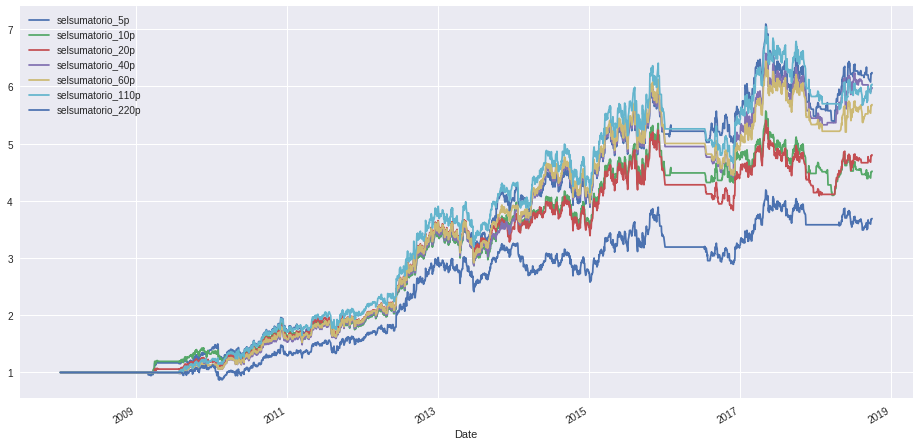

In [49]:
selsuma=[x for x  in cum_daily_return.filter(like='sumatorio',axis=1).columns]
selsumados=[ 'sel{}'.format(x) for x  in cum_daily_return.filter(like='sumatorio',axis=1).columns]

for row in selsuma:
  cum_daily_return['sel{}'.format(row)]=np.exp(cum_daily_return[row].cumsum().fillna(0))
  
cum_daily_return[selsumados].plot(figsize=(16,8))

In [50]:
perf=cum_daily_return[selsumados].dropna().calc_stats()


/usr/local/lib/python3.6/dist-packages/ffn/core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


In [51]:
resultados=perf.stats.T
#print (resultados.columns)
resultados[datos][resultados.cagr>.2]


,total_return,cagr,max_drawdown,calmar,daily_sharpe,daily_sortino,monthly_sharpe,monthly_sortino,best_month,worst_month,yearly_sharpe,best_year,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc


In [52]:
resultados[datos][resultados.monthly_sharpe>.9]

,total_return,cagr,max_drawdown,calmar,daily_sharpe,daily_sortino,monthly_sharpe,monthly_sortino,best_month,worst_month,yearly_sharpe,best_year,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc
selsumatorio_110p,5.03735,0.182125,-0.2726,0.668103,0.855195,1.48746,1.03744,2.32243,0.220144,-0.136262,0.842461,0.850562,-0.00909007,-0.0413316,24.7661,0.046564,-0.0229968,0.9,0.789916
selsumatorio_20p,3.80227,0.157214,-0.267946,0.586738,0.760403,1.32637,0.918953,2.08381,0.220144,-0.139754,0.722063,0.850562,-0.067127,-0.047987,32.43,0.0483513,-0.0219415,0.8,0.789916
selsumatorio_40p,4.97658,0.181013,-0.269856,0.670775,0.847887,1.47787,1.04592,2.37114,0.220144,-0.139754,0.863885,0.850562,-0.00131334,-0.0437656,28.5446,0.0467359,-0.0222815,0.9,0.781513
selsumatorio_5p,5.24031,0.185768,-0.242732,0.765323,0.863125,1.48748,1.00594,2.09384,0.220144,-0.175041,0.871483,0.850562,0.0021297,-0.0416361,31.3077,0.0500471,-0.026295,1,0.857143
selsumatorio_60p,4.68152,0.175462,-0.273443,0.641676,0.828012,1.43838,1.00596,2.24143,0.220144,-0.139754,0.818587,0.850562,-0.0472324,-0.0428511,27.8919,0.0457636,-0.0230853,0.9,0.781513


In [53]:
resultados[datos][resultados.win_year_perc==1]

,total_return,cagr,max_drawdown,calmar,daily_sharpe,daily_sortino,monthly_sharpe,monthly_sortino,best_month,worst_month,yearly_sharpe,best_year,worst_year,avg_drawdown,avg_drawdown_days,avg_up_month,avg_down_month,win_year_perc,twelve_month_win_perc
selsumatorio_5p,5.24031,0.185768,-0.242732,0.765323,0.863125,1.48748,1.00594,2.09384,0.220144,-0.175041,0.871483,0.850562,0.0021297,-0.0416361,31.3077,0.0500471,-0.026295,1,0.857143


In [55]:
for n in selsumados:
  print('******',n,'*******\n\n')
  perf[n].display_monthly_returns()
  print('\n\n')

****** selsumatorio_5p *******


  Year    Jan     Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct    Nov     Dec    YTD
------  -----  ------  -----  -----  -----  -----  -----  -----  -----  -----  -----  ------  -----
  2008   0       0      0      0      0      0      0      0      0      0      0       0      0
  2009   0       0      5.39  10.72   0      0      0.33   3.71  -3.73   5.57   7.17    4.91  38.72
  2010   6.63  -17.5   11.12  -3.8    1.77   3.68   7.78   3.74  10.67   2.99   1.94   -3.5   24.39
  2011   0.19    3.75  -6.56   6.39   6.16  -0.52  -1.04  -6.08   8.53  -3.59   0.57    0.4    7.14
  2012   5.4     3.91   3.62  -5.39   5.31  22.01   2.82   5.46   9.3    1.87  10.98    0.09  85.06
  2013  -2.18   -0.53   0.73  -1.31  -0.38  -5.56   6.75  -1.99  12.92  13.13  -1.94   -0.84  18.26
  2014  -0.84    0.22  -0.89   3.79   3.82   1.41   0.99   0.57   0.28  -5.58   3.14   -5.97   0.38
  2015  10.25    7.46   6.39  -4.03   6.14  -3.33   6.93  -4.6    0.64

In [56]:
type(perf)

ffn.core.GroupStats